In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.Pipelines.skypy_pipeline import SkyPyPipeline
from slsim.Pipelines.sl_hammocks_pipeline import SLHammocksPipeline
from slsim.Deflectors.compound_lens_halos_galaxies import CompoundLensHalosGalaxies
import slsim.Sources as sources
from slsim.lens_pop import LensPop
from slsim.image_simulation import simulate_image
from slsim.image_simulation import rgb_image_from_image_list
import slsim.Deflectors as deflectors
from slsim.Sources.source import Source
from slsim.Deflectors.deflector import Deflector
from slsim.lens import Lens
from slsim.LOS.los_individual import LOSIndividual
import corner

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# define a cosmology
cosmology2 = FlatLambdaCDM(H0=70, Om0=0.3)
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.05)

# define a sky area
sky_area = Quantity(value=5, unit="deg2")
sky_area_deflector = Quantity(value=10, unit="deg2")
sky_area_full = Quantity(value=10, unit="deg2")

# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 28, "z_min": 0.01, "z_max": 2}
kwargs_source_cut = {"band": "g", "band_max": 28, "z_min": 0.1, "z_max": 5.0}

In [3]:
# Generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = SkyPyPipeline(
    skypy_config=None, sky_area=sky_area, filters=None, cosmo=cosmo
)

In [4]:
#manually change z_min and z_max
halo_galaxy_pipeline = SLHammocksPipeline(
                slhammocks_config=None,
                sky_area=sky_area_deflector,
                cosmo=cosmo,
                z_min=0.01,
                z_max=2,
                loghm_min=13,
                loghm_max=16
            )

In [5]:
halo_galaxies=halo_galaxy_pipeline.halo_galaxies

In [6]:
len(halo_galaxy_pipeline.halo_galaxies)

7494

In [7]:
min(halo_galaxy_pipeline.halo_galaxies["mag_i"]), max(halo_galaxy_pipeline.halo_galaxies["mag_i"])

(12.650959620109663, 28.08041051529588)

In [8]:
lens_galaxies=CompoundLensHalosGalaxies(
                halo_galaxy_list=halo_galaxies,
                kwargs_cut=kwargs_deflector_cut,
                kwargs_mass2light={},
                cosmo=cosmo,
                sky_area=sky_area,
            )

In [9]:
# Initiate source population class.
source_galaxies = sources.Galaxies(
    galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_source_cut,
    cosmo=cosmo,
    sky_area=sky_area,
    catalog_type="skypy",
)

In [10]:
# make galaxy-galaxy population class using LensPop
gg_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_galaxies,
    cosmo=cosmo,
    sky_area=sky_area_full,
)

In [11]:
kwargs_lens_cut = {"min_image_separation": 0.8, "max_image_separation":10}
lens_population = gg_lens_pop.draw_population(kwargs_lens_cuts=kwargs_lens_cut)

In [3]:
import pickle

In [11]:
with open('/Users/narayankhadka/Desktop/strong_lensing/slhammock_lens_sample_with_high_theta_e.pkl', 'wb') as f:
    pickle.dump(lens_class_cut, f)

In [13]:
np.save('/Users/narayankhadka/Desktop/strong_lensing/slhammock_lens_sample_10deg2_sample_9.npy', lens_samples)

In [4]:
with open('/Users/narayankhadka/Desktop/strong_lensing/slhammock_lens_sample_100deg2.pkl', 'rb') as f:
    lens_population = pickle.load(f)

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
len(lens_population)

998

In [ ]:
theta_e=[]
theta_e_infinity=[]
zl=[]
lens_class_cut=[]
for lens_class in lens_population:
    if lens_class.einstein_radius[0] > 8:
        theta_e.append(lens_class.einstein_radius[0])
        lens_class_cut.append(lens_class)
    theta_e_infinity.append(lens_class.einstein_radius_infinity[0])
    zl.append(lens_class.deflector_redshift)"""

In [12]:
len(lens_class_cut)

16

In [24]:
lens_class_cut[0].einstein_radius

[10.218792718031837]

In [25]:
lens_class_cut[0].einstein_radius_infinity

[3.7688193631458824]

In [ ]:
[10.46809367475159], [3.7688193631458824]

In [ ]:
zs=0.8664718175006184
zl=0.09199999999999993
deflector_angular_size_light=9.893988634937736
halo_mass=259737421577890.4, 
concentration=7.314407077851028
source_size=0.01345195778342412
stellar_mass=1064901910393.4458
mag_i_l = 13.80785703495668
mag_i_s=26.00614079444494

In [ ]:
print(lens_class_cut[0].source_redshift_list[0])
print(lens_class_cut[0].deflector_redshift)
print(lens_class_cut[0].deflector.angular_size_light)
print(lens_class_cut[0].deflector.halo_properties)
print(lens_class_cut[0]._source[0].angular_size)


0.8664718175006184
0.09199999999999993
9.893988634937736
(259737421577890.4, 7.314407077851028)
0.01345195778342412


In [47]:
theta_e, theta_e_infinity

([0.9327388361920268,
  1.7634874463241494,
  0.9729861410040437,
  1.3381108726231883,
  2.6711696778826886,
  0.6800029276038193,
  0.6010825379744964,
  1.9410078602109637,
  0.8700722213937757],
 [2.6046851307988104,
  2.326729625749312,
  2.19554597369719,
  4.758208464407321,
  4.973404777026768,
  1.8001241391495588,
  2.1738947245148514,
  4.5864429469619585,
  2.070575973105803])

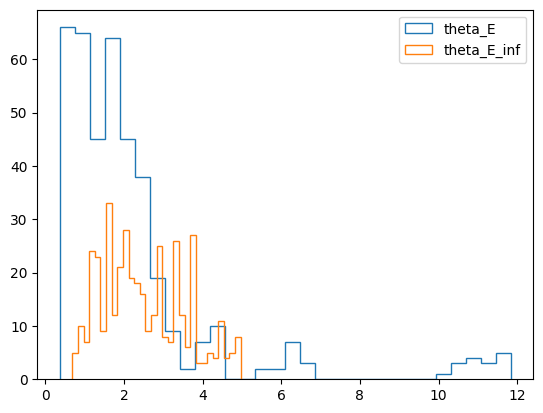

In [48]:
plt.hist(theta_e, bins=30, histtype="step", label="theta_E")
plt.hist(theta_e_infinity, bins=30, histtype="step", label="theta_E_inf")
plt.legend()

In [28]:
sum(theta_e), sum(theta_e_infinity)

(883.9913753177877, 1005.5150401611276)

In [27]:
14.781574103617963/8.171968551277308

1.8088143647233628

In [29]:
1005.5150401611276/883.9913753177877

1.1374715503300619

In [15]:
print("Number of lenses:", len(lens_population))

lens_samples = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\log(h_{m})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm source}$",
    r"$m_{\rm lens}$",
]

for gg_lens in lens_population:
    vel_disp = gg_lens.deflector_velocity_dispersion()
    m_star = gg_lens.deflector_stellar_mass()
    halo_mass = gg_lens.deflector.halo_properties[0]
    theta_e = gg_lens.einstein_radius[0]
    zl = gg_lens.deflector_redshift
    zs = gg_lens.source_redshift_list[0]
    source_mag = gg_lens.extended_source_magnitude(band="i", lensed=True)[0]
    deflector_mag = gg_lens.deflector_magnitude(band="i")
    lens_samples.append(
        [vel_disp, np.log10(m_star), np.log10(halo_mass), theta_e, zl, zs, source_mag, deflector_mag]
    )

Number of lenses: 763


In [14]:
lens_cut=[]
for i in range(len(lens_population)):
    if lens_population[i].extended_source_magnitude(band="g", lensed=True)[0] > 28:
        lens_cut.append(lens_population[i])

In [20]:
lens_cut[1].extended_source_magnitude(band="g", lensed=False)[0]

25.1530838446213

In [21]:
lens_cut[1]._source[0].extended_source_magnitude(band="g")

25.1530838446213

In [24]:
np.log10(10**-1)

-1.0

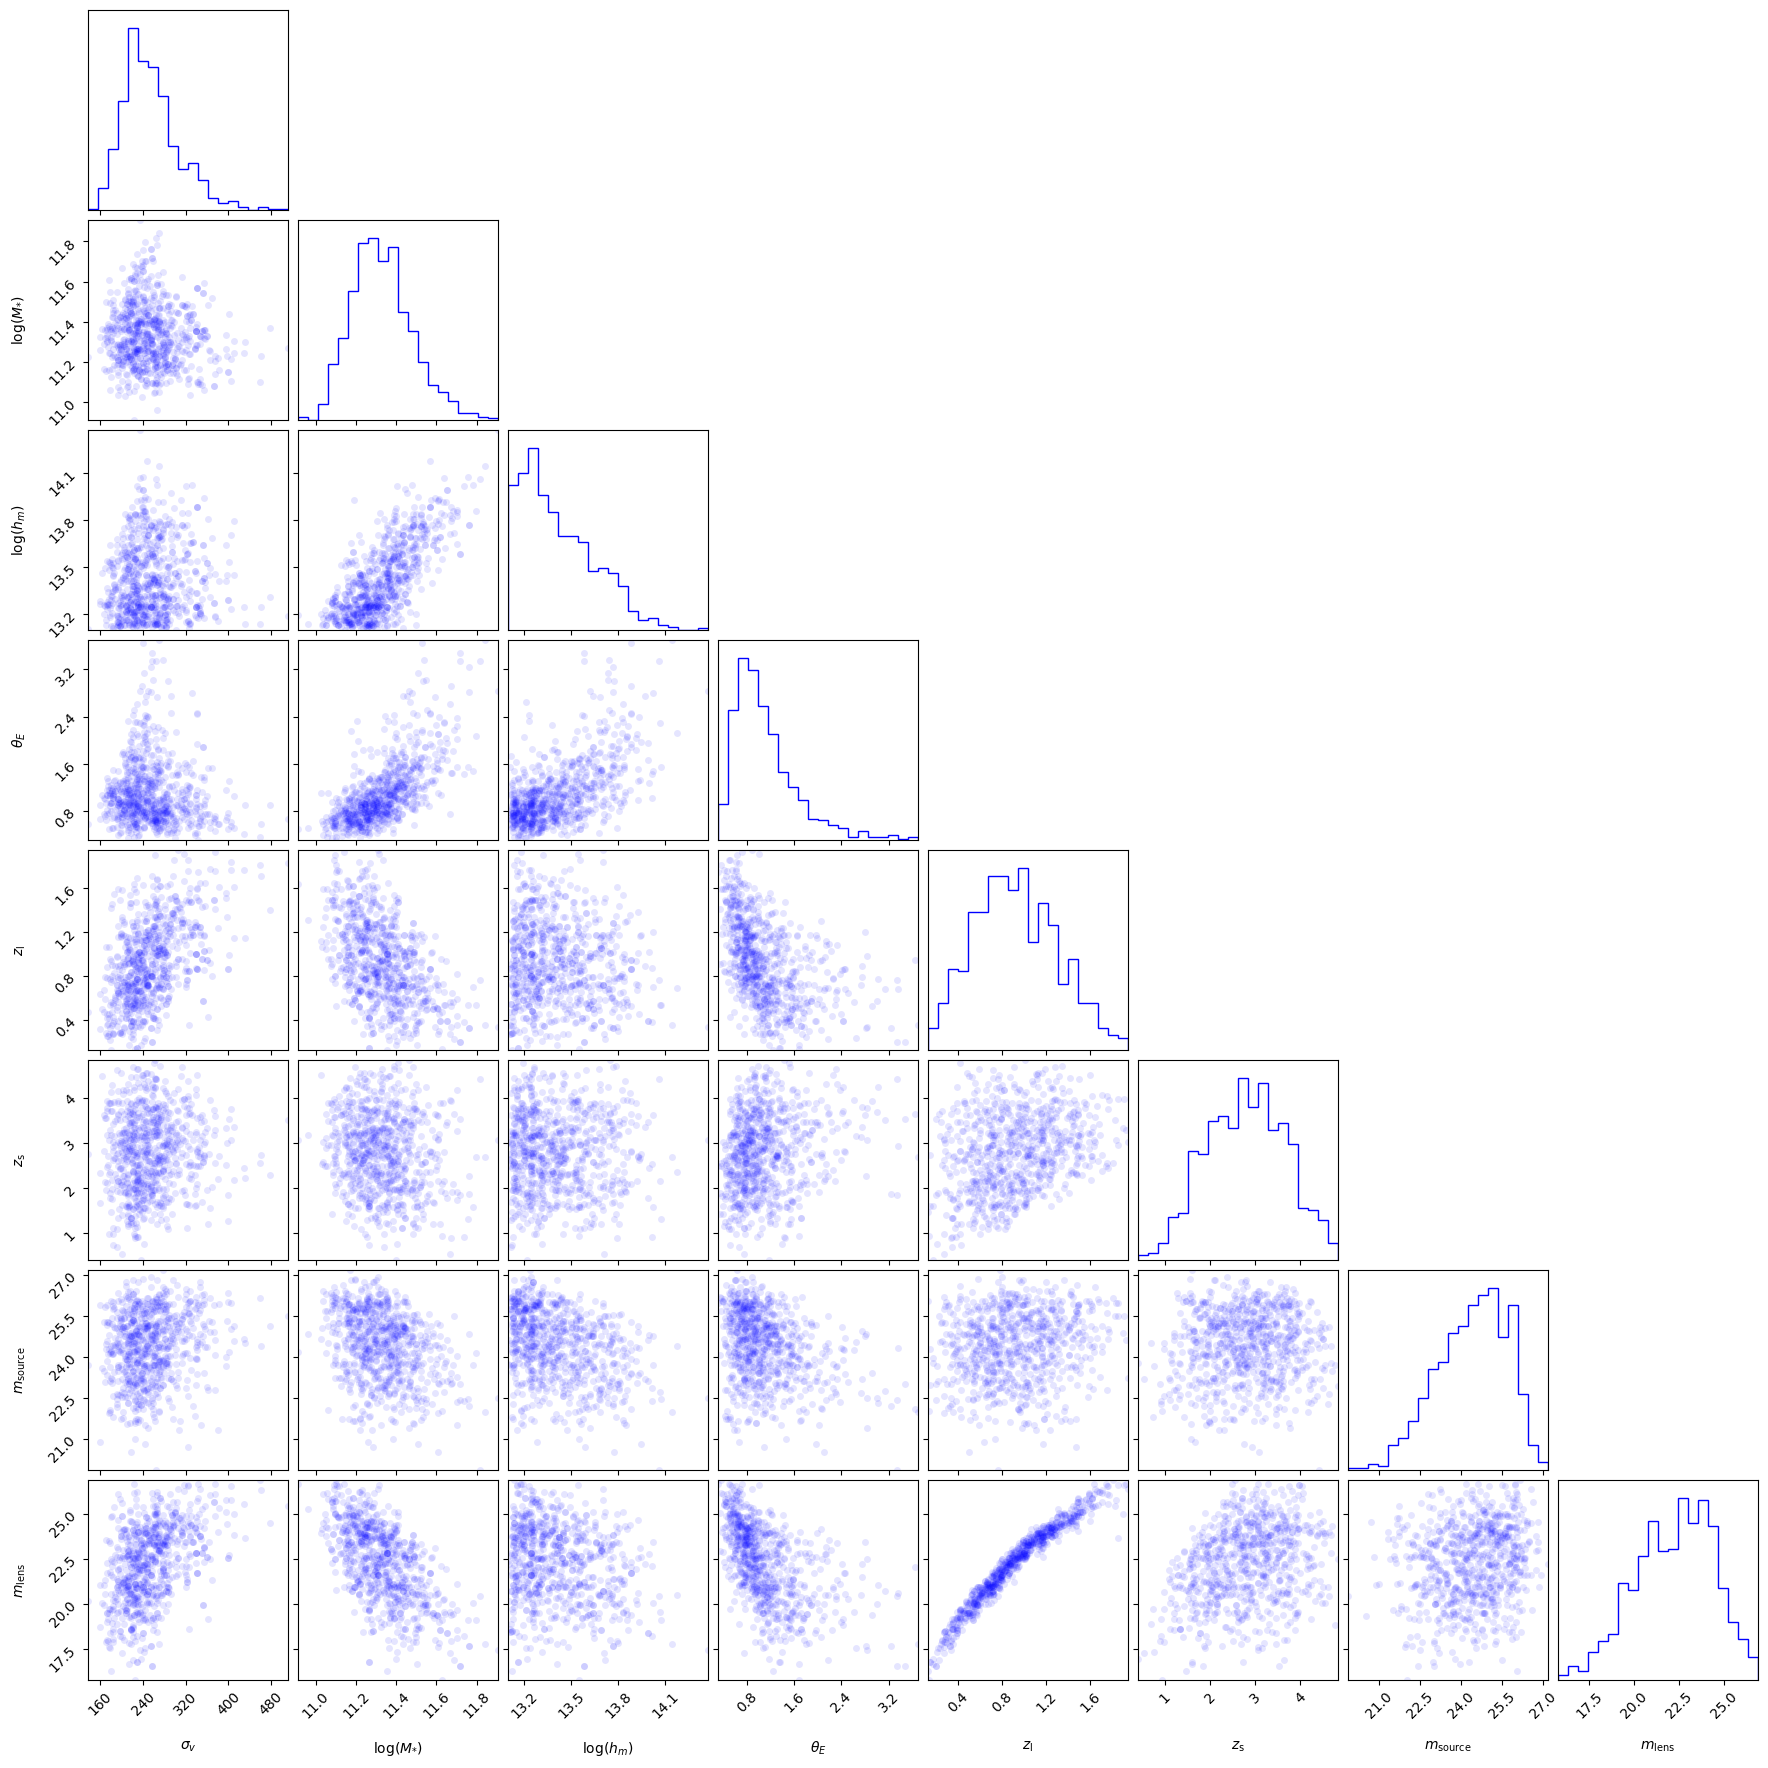

In [16]:
hist2dkwargs = {
    "plot_density": False,
    "plot_contours": False,
    "plot_datapoints": True,
    "color": "b",
    "data_kwargs": {"ms": 5},
}
corner.corner(np.array(lens_samples), labels=labels, **hist2dkwargs)
plt.show()

In [22]:
time = np.linspace(-32, 45, 78)
# time = sorted(np.random.uniform(-20, 100, 10))
# time = np.array([0, 50, 70, 120])
repeats = 1
# load your psf kernel and transform matrix. If you have your own psf, please provide
# it here.
path_i = "/Users/narayankhadka/downloads/sample_psf_i.npy"
path_r = "/Users/narayankhadka/downloads/sample_psf_r.npy"
path_g = "/Users/narayankhadka/downloads/sample_psf_g.npy"
psf_kernel_i = 1 * np.load(path_i)
psf_kernel_r = 1 * np.load(path_r)
psf_kernel_g = 1 * np.load(path_g)
"""psf_kernel[psf_kernel < 0] = 0
transform_matrix = np.array([[0.2, 0], [0, 0.2]])

# let's set up psf kernel for each exposure. Here we have taken the same psf that we
# extracted above. However, each exposure can have different psf kernel and user should
# provide corresponding psf kernel to each exposure.
psf_kernel_list = [psf_kernel]
transform_matrix_list = [transform_matrix]
psf_kernels_all = psf_kernel_list * repeats
# psf_kernels_all = np.array([dp0["psf_kernel"][:10]])[0]"""

# let's set pixel to angle transform matrix. Here we have taken the same matrix for
# each exposure but user should provide corresponding transform matrix to each exposure.
transform_matrix = np.array([[0.2, 0], [0, 0.2]])
transform_matrix_list = [transform_matrix]
transform_matrix_all = transform_matrix_list * repeats

# provide magnitude zero point for each exposures. Here we have taken the same magnitude
#  zero point for each exposure but user should provide the corresponding magnitude
# zero point for each exposure.
mag_list = [31.0]
mag_zero_points_all = mag_list * repeats
# mag_zero_points_all = np.array([dp0["zero_point"][:10]])[0]

expo_list = [30]
exposure_time_all = expo_list * repeats

In [23]:
lens_population[0].lenstronomy_kwargs("i")

({'lens_light_model_list': ['HERNQUIST_ELLIPSE'],
  'lens_model_list': ['NFW_ELLIPSE_CSE',
   'HERNQUIST_ELLIPSE_CSE',
   'SHEAR',
   'CONVERGENCE'],
  'source_light_model_list': ['SERSIC_ELLIPSE']},
 {'kwargs_lens': [{'alpha_Rs': 2.438432593443759,
    'Rs': 36.68232305992119,
    'center_x': 0.05617216149135682,
    'center_y': 0.07903841068129391,
    'e1': 0.034673932724860065,
    'e2': -0.20318325183458757},
   {'Rs': 0.6340339357716712,
    'sigma0': 3.179368084714484,
    'center_x': 0.05617216149135682,
    'center_y': 0.07903841068129391,
    'e1': 0.016939952326817706,
    'e2': -0.2595343558973028},
   {'gamma1': 0.014069126827658514,
    'gamma2': -0.011521955269137315,
    'ra_0': 0,
    'dec_0': 0},
   {'kappa': 0.05152765924648948, 'ra_0': 0, 'dec_0': 0}],
  'kwargs_source': [{'magnitude': 24.776441571970764,
    'R_sersic': 0.08745867995082914,
    'n_sersic': 1.0,
    'e1': -0.026367889446021982,
    'e2': -0.08274645494535239,
    'center_x': 0.020323264584680555,
  

In [24]:
from slsim.image_simulation import lens_image, rgb_image_from_image_list
image_i_list=[]
image_r_list=[]
image_g_list=[]
for lens_class in lens_population:
    image_i=lens_image(
            lens_class=lens_class,
            band="i",
            mag_zero_point=27,
            num_pix=51,
            psf_kernel=psf_kernel_i,
            transform_pix2angle=transform_matrix,
            exposure_time=None,
            t_obs=None,
            std_gaussian_noise=None,
            with_source=True,
            with_deflector=True,
        )
    image_r=lens_image(
        lens_class=lens_class,
        band="r",
        mag_zero_point=27,
        num_pix=51,
        psf_kernel=psf_kernel_r,
        transform_pix2angle=transform_matrix,
        exposure_time=None,
        t_obs=None,
        std_gaussian_noise=None,
        with_source=True,
        with_deflector=True,
    )

    image_g=lens_image(
        lens_class=lens_class,
        band="g",
        mag_zero_point=27,
        num_pix=51,
        psf_kernel=psf_kernel_g,
        transform_pix2angle=transform_matrix,
        exposure_time=None,
        t_obs=None,
        std_gaussian_noise=None,
        with_source=True,
        with_deflector=True,
)
    image_i_list.append(image_i)
    image_r_list.append(image_r)
    image_g_list.append(image_g)

/Users/narayankhadka/lenstronomy/lenstronomy/Data/psf.py:95: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(


In [25]:
rgb_image_list=[]
for i in range(len(image_i_list)):
    rgb_image=rgb_image_from_image_list([image_i_list[i], image_r_list[i], image_g_list[i]], stretch=0.5)
    rgb_image_list.append(rgb_image)

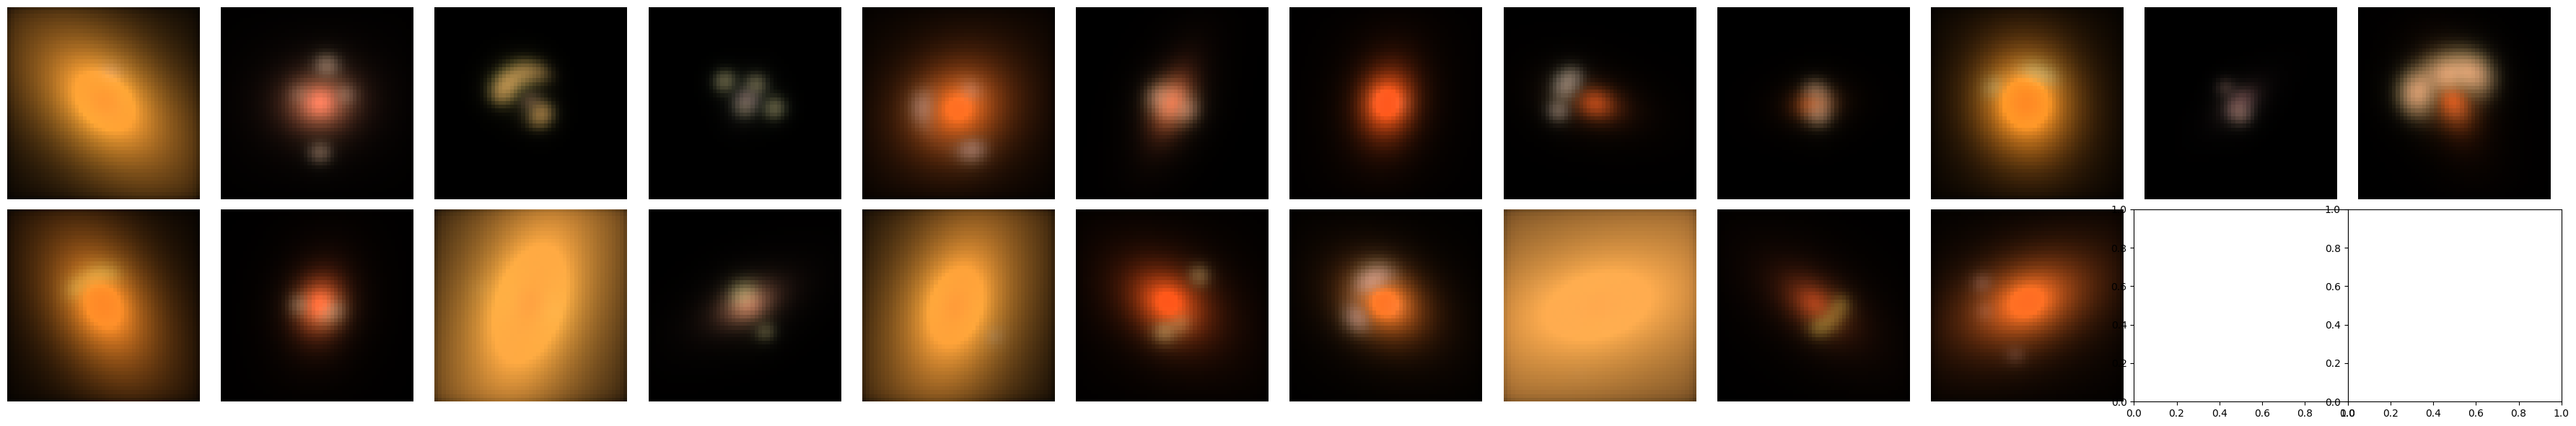

In [26]:
import numpy as np
from slsim.Plots.plot_functions import create_image_montage_from_image_list
index=np.linspace(0, 1*22-1, 22)
#index=np.random.randint(0, len(rgb_image_list), 500)
#index=np.random.randint(0, 3000, 500)
#index=np.array([0, 303])
selected_image=[]
for i in index:
    selected_image.append(rgb_image_list[int(i)])
x=create_image_montage_from_image_list(
    num_rows=2, num_cols=12, images=selected_image, time=None, image_type="other"
)

In [109]:
from slsim.Deflectors.halo_population import calc_vol
from colossus.cosmology import cosmology

In [110]:
sigma8 = 0.8102  # from Planck18 TT,TE,EE+lowE+lensing+BAO best-fit value
ns = 0.9660499  # from Planck18 TT,TE,EE+lowE+lensing+BAO best-fit value
cosmo_col = cosmology.fromAstropy(cosmo, sigma8, ns, cosmo_name="my_cosmo")

In [14]:
v1=calc_vol(1.5, cosmo_col)

In [20]:
v1

10703485.67582541

In [42]:
v4=(cosmo.differential_comoving_volume(1.5) * sky_area).to_value("Mpc3")
v4

57409327.31440155

In [26]:
(v2-v1)*100/v2

79.99996776833046

In [27]:
from astropy.cosmology import Planck18 as cosmo  # or any cosmology model
import numpy as np

def calc_vol_astropy_differential(z, cosmo_astropy):
    """
    Calculate the cosmological differential comoving volume per unit redshift per square degree.

    Parameters
    -----------------------------------------------------------------------------------------------
    :param z: Redshift
    :type z : float
    :param cosmo_astropy: Astropy cosmology instance
    :type cosmo_astropy: astropy.cosmology.FLRW instance

    Returns
    -----------------------------------------------------------------------------------------------
    volume: float
        Volume element [Mpc^3 / deg^2 / unit redshift]
    """
    # differential_comoving_volume returns dV_c / dz / dΩ in [Mpc^3 / sr]
    dVdz_dOmega = cosmo_astropy.differential_comoving_volume(z)  # units: Mpc³/sr

    # Convert from steradian to square degree
    steradian_to_deg2 = (180.0 / np.pi)**2  # ≈ 3282.80635

    # Divide by steradian_to_deg2 to get per deg²
    dVdz_per_deg2 = (dVdz_dOmega / steradian_to_deg2).value  # final float value

    return dVdz_per_deg2


In [29]:
v2=calc_vol_astropy_differential(1.5, cosmo)

In [32]:
(v2-v1)*100/v2

6.779210134200944

In [44]:
from astropy.cosmology import Planck18 as cosmo  # or your chosen cosmology
import astropy.units as u
from astropy import constants as const

def calc_vol_astropy2(z, cosmo_astropy):
    """
    Calculate the cosmological volume element per unit redshift per square degree at redshift z.

    Parameters
    -----------------------------------------------------------------------------------------------
    :param z: Redshift
    :type z : float
    :param cosmo_astropy: An instance of an astropy cosmology model
    :type cosmo_astropy: astropy.cosmology.FLRW instance

    Returns
    -----------------------------------------------------------------------------------------------
    volume: float
        Volume element [Mpc^3 / deg^2 / unit redshift]
    """
    # Angular diameter distance [Mpc]
    DA = cosmo_astropy.angular_diameter_distance(z).to(u.Mpc)

    # dr/dz = c / H(z)
    drdz = (const.c / cosmo_astropy.H(z)).to(u.Mpc)

    # Comoving transverse distance D_M = (1+z) * D_A
    DM = DA * (1 + z)

    # Solid angle conversion: 1 steradian = (180/pi)^2 deg^2
    steradian_to_deg2 = (180.0 / np.pi)**2  # ≈ 3282.80635

    # Volume element per unit z per deg²
    dV = (DM**2 * drdz / steradian_to_deg2)  # remove units at the end

    return dV


In [45]:
v3=calc_vol_astropy2(1.5, cosmo)*sky_area

In [46]:
v4, v3.value

(57409327.31440155, 57409327.31440155)

In [ ]:
def redshifts_from_comoving_density(redshift, sky_area, cosmo):
    

    # redshift number density
    dN_dz = (cosmo.differential_comoving_volume(redshift) * sky_area).to_value("Mpc3")
    return dN_dz

In [5]:
from slsim.Pipelines.sl_hammocks_pipeline import halo_galaxy_population

In [ ]:
kwargs_population_base = {
                "z_min": 0.01,
                "z_max": 2,
                "log10host_halo_mass_min": 13,
                "log10host_halo_mass_max": 16,
                "sigma_host_halo_concentration": 0.33,
                "sigma_central_galaxy_mass": 0.2,
                "TYPE_GAL_SIZE": "vdW23",
                "sig_tb": 0.46,
                "frac_SM_IMF": 1.715,
                "TYPE_SMHM": "true",
                "sigma8": 0.8102,
                "ns": 0.9660499,
            }

table = halo_galaxy_population(sky_area, cosmo, **kwargs_population_base)

In [6]:
kwargs_population_base2 = {
                "z_min": 0.01,
                "z_max": 2,
                "log10host_halo_mass_min": 13,
                "log10host_halo_mass_max": 16,
                "sigma_host_halo_concentration": 0.33,
                "sigma_central_galaxy_mass": 0.2,
                "TYPE_GAL_SIZE": "vdW23",
                "sig_tb": 0.46,
                "frac_SM_IMF": 1.715,
                "TYPE_SMHM": "true",
                "sigma8": 0.8102,
                "ns": 0.9660499,
            }

table2 = halo_galaxy_population(sky_area, cosmo, **kwargs_population_base2)

In [7]:
table2[0]

z,halo_mass,halo_mass_acc,e_h,p_h,concentration,stellar_mass,ellipticity,p_g,tb
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.029999999999999985,10399201658290.367,0.0,0.34049538984655614,-174.965909579835,8.414001276569119,149602869685.21503,0.28941334841046573,-167.73300892443498,5.706174414580619
0.10299999999999991,17579236139581.43,0.0,0.29036830901456134,29.504096630571745,7.603868816316679,162414401701.3166,0.3013016449720597,21.64650527899084,3.2254009650021156
0.12599999999999992,68706844001349.83,0.0,0.3701606300637751,-25.252461676478852,8.483609250864081,448099726039.7583,0.36109685562333904,6.873615929794319,3.512215070708067
0.15299999999999989,15703628043331.598,0.0,0.3630476495331443,179.77292949986298,6.6577375299756705,173793021756.43106,0.26550652319527274,177.77672792165626,1.3504892793212888
0.16499999999999987,10092528860766.793,0.0,0.3181349677229184,101.76859452179758,5.81446463246294,137298894152.194,0.31986317034634626,45.404140717957375,1.6022377230752365
0.17099999999999987,11830415557250.545,0.0,0.2913482209000715,-67.00343089731848,6.350052709086413,131162943413.96571,0.5953487372553088,-105.14063576328532,0.40585887489480404
0.19799999999999984,32433961734913.773,0.0,0.21405137829627469,83.30670377514348,4.24277795187441,304540674337.6896,0.324394193235827,12.563277182227779,1.4083073753331066
0.20699999999999985,11428783347896.871,0.0,0.36346667199770977,172.12471538312937,5.599451494590507,156102503031.41913,0.35899695524848735,149.2470127512323,0.42231696926857154
0.21499999999999983,29174270139994.355,0.0,0.2536898585617597,174.26175746452927,15.57115471450316,272939379849.30304,0.23995277779465823,162.24603730570675,0.29806461508842536


In [7]:
from slsim.Pipelines.sl_hammocks_pipeline import table_translator_for_slsim

In [8]:
table_slsim=table_translator_for_slsim(table2[0], cosmo)

In [124]:
1.9628396871135392/0.551

3.5623224811497987

In [125]:
58924256709.910324/0.7

84177509585.58618

In [14]:
2992012451235.9653*0.7-1883649089489.1394

210759626376.03613

In [15]:
3979296562111.774*0.7-2471724145014.8906

313783448463.3511

In [111]:
hubble = cosmo_col.H0 / 100.0

In [113]:
hubble

0.7

In [101]:
from colossus.halo import mass_defs

In [133]:
mass_defs.changeMassDefinition(table2[0]["halo_mass"][0], table2[0]["concentration"][0], table2[0]["z"][0], "vir", "200m")

(1766495598737.859, 284.55819713350934, 7.680034210250056)

In [123]:
1085004885545.6111/0.7

1550006979350.873

(array([ 39., 139., 222., 298., 350., 397., 415., 380., 351., 322., 278.,
        234., 175., 143., 111.,  75.,  75.,  41.,  33.,  38.,  10.,  11.,
         10.,   7.,   5.,   4.,   2.,   1.,   2.,   2.]),
 array([0.061     , 0.20153333, 0.34206667, 0.4826    , 0.62313333,
        0.76366667, 0.9042    , 1.04473333, 1.18526667, 1.3258    ,
        1.46633333, 1.60686667, 1.7474    , 1.88793333, 2.02846667,
        2.169     , 2.30953333, 2.45006667, 2.5906    , 2.73113333,
        2.87166667, 3.0122    , 3.15273333, 3.29326667, 3.4338    ,
        3.57433333, 3.71486667, 3.8554    , 3.99593333, 4.13646667,
        4.277     ]),
 [<matplotlib.patches.Polygon at 0x140cc1490>])

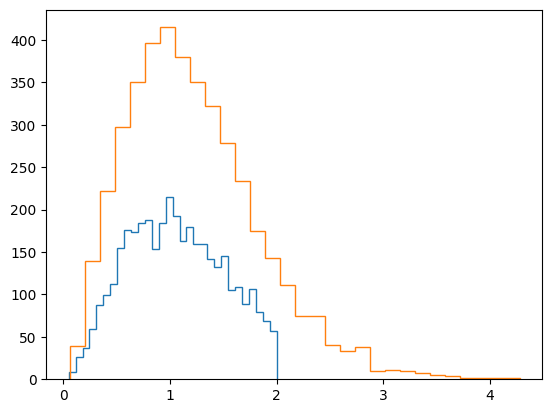

In [17]:
plt.hist(table[0]["z"], bins=30, histtype="step")
plt.hist(table2[0]["z"], bins=30, histtype="step")

In [33]:
indices = np.nonzero(np.array([1,2,0,4]))

In [34]:
indices

(array([0, 1, 3]),)

In [11]:
from colossus.lss import mass_function

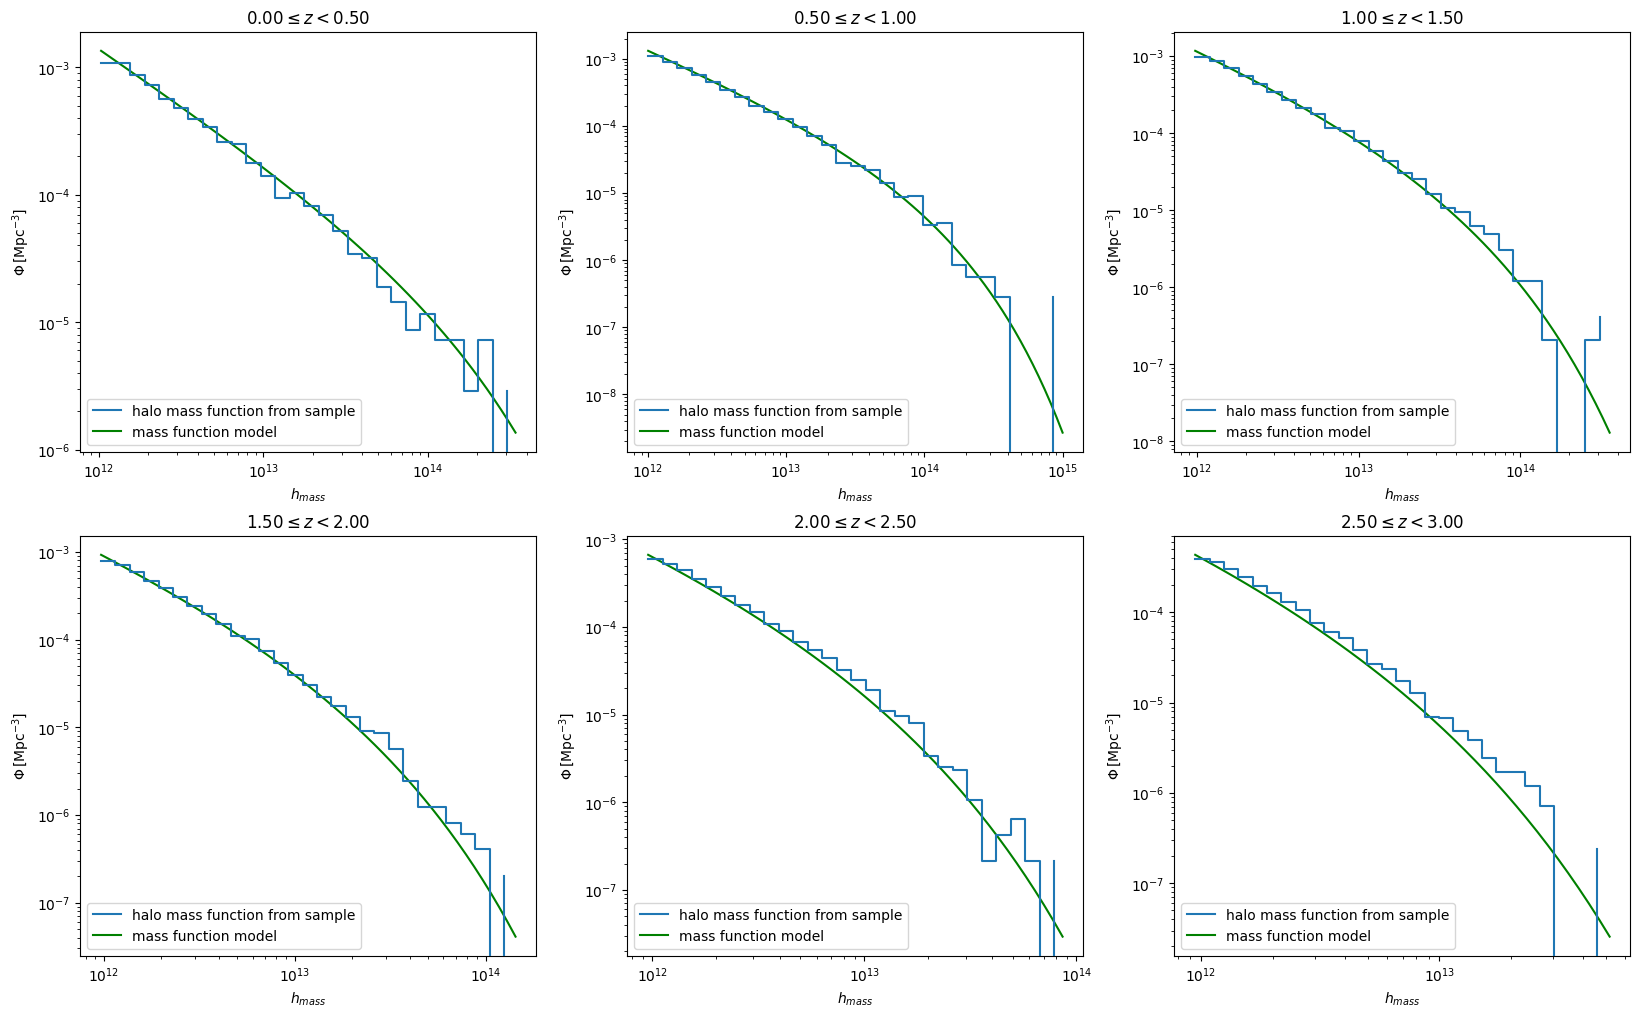

In [12]:

red_galaxies_1 = table2[0]
redshift, halo_mass = red_galaxies_1["z"], red_galaxies_1["halo_mass"]


fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
    nrows=2, ncols=3, figsize=(20, 12)
)
#bins = np.linspace(13, 16, 40)
z_slices = ((0.0, 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, 3))

for ax, (z_min, z_max) in zip([ax1, ax2, ax3, ax4, ax5, ax6], z_slices):

    # Redshift grid
    z = np.linspace(z_min, z_max, 100)

    # SkyPy simulated galaxies
    z_mask = np.logical_and(redshift >= z_min, redshift < z_max)
    halo_mass_bin = np.log(halo_mass[z_mask]*0.7)
    #print(halo_mass_bin)
    bins = np.linspace(min(halo_mass_bin), max(halo_mass_bin), 30)
    #print(bins)
    dV_dz = (cosmology2.differential_comoving_volume(z) * sky_area).to_value("Mpc3")
    #print(dV_dz)
    dV = np.trapz(dV_dz, z)
    #print(dV)
    dM = (np.max(bins) - np.min(bins)) / (np.size(bins) - 1)
    #print(dM)
    phi_first_red = np.histogram(np.log(halo_mass[z_mask]*0.7), bins=bins)[0] /dV/ dM

    # Median-redshift Schechter function
    M = np.exp(1)**np.arange(min(halo_mass_bin), max(halo_mass_bin), 0.1)
    phi_model = mass_function.massFunction(M, np.mean(z), mdef="200m", model="tinker08", q_out="dndlnM")*(0.7**3)
    # Plotting
    ax.step(
        np.exp(1)**bins[:-1],
        phi_first_red,
        where="post",
        label="halo mass function from sample",
        zorder=3,
    )
    
    ax.plot(M, phi_model, label="mass function model", color="g")
    ax.set_title(r"${:.2f} \leq z < {:.2f}$".format(z_min, z_max))
    ax.set_xlabel(r"$h_{mass}$")
    ax.set_ylabel(r"$\Phi \, [\mathrm{Mpc}^{-3}]$")
    ax.loglog()
    #ax.set_yscale("log")
    # ax.set_xlim([-14, -24])
    # ax.set_ylim([min(magnitude_bin), None])
    ax.legend(loc="lower left")
    #ax.invert_xaxis()
plt.show()

/var/folders/2l/53gnsztn5m55tknx49g_n74h0000gn/T/ipykernel_6022/1645291008.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10")  # or 'viridis', 'Set1', etc.


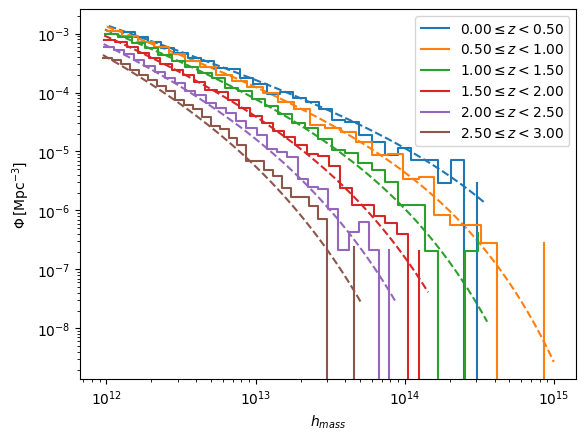

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap

fig, ax = plt.subplots()
cmap = get_cmap("tab10")  # or 'viridis', 'Set1', etc.
n_slices = len(z_slices)

for i, (z_min, z_max) in enumerate(z_slices):
    color = cmap(i % cmap.N)  # loop safely even if more slices than cmap colors

    # Redshift grid
    z = np.linspace(z_min, z_max, 100)

    # Mask and bins
    z_mask = np.logical_and(redshift >= z_min, redshift < z_max)
    halo_mass_bin = np.log(halo_mass[z_mask]*0.7)
    bins = np.linspace(min(halo_mass_bin), max(halo_mass_bin), 30)

    dV_dz = (cosmology2.differential_comoving_volume(z) * sky_area).to_value("Mpc3")
    dV = np.trapz(dV_dz, z)
    dM = (np.max(bins) - np.min(bins)) / (np.size(bins) - 1)

    phi_first_red = np.histogram(np.log(halo_mass[z_mask]*0.7), bins=bins)[0] / dV / dM

    # Schechter / mass function model
    M = np.exp(1)**np.arange(min(halo_mass_bin), max(halo_mass_bin), 0.1)
    phi_model = mass_function.massFunction(M, np.mean(z), mdef="200m", model="tinker08", q_out="dndlnM")*(0.7**3)

    # Plot both with the same color
    ax.step(
        np.exp(1)**bins[:-1],
        phi_first_red,
        where="post",
        label=r"${:.2f} \leq z < {:.2f}$".format(z_min, z_max),
        color=color,
        zorder=3,
    )
    ax.plot(M, phi_model, ls="--", color=color)

ax.set_xlabel(r"$h_{mass}$")
ax.set_ylabel(r"$\Phi \, [\mathrm{Mpc}^{-3}]$")
ax.loglog()
ax.legend(loc="upper right")


In [1]:
5e1

50.0

In [27]:
from skypy.galaxies.spectrum import KCorrectTemplates
from skypy.galaxies.spectrum import dirichlet_coefficients

In [28]:
skypy_class=KCorrectTemplates()

In [15]:
alpha0= [2.461, 2.358, 2.568, 2.268, 2.402]
alpha1= [2.410, 2.340, 2.200, 2.540, 2.464]
weight= [3.84e+09, 1.57e+06, 3.91e+08, 4.66e+10, 3.03e+07]

In [24]:
filters= ['lsst2016-g', 'lsst2016-r', 'lsst2016-i', 'lsst2016-z', 'lsst2016-y']

In [22]:
coeff = dirichlet_coefficients(redshift=1, alpha0=alpha0, alpha1=alpha1, weight=weight)

In [23]:
coeff

array([2.06467887e-02, 1.14527927e-05, 6.76354829e-03, 9.72164289e-01,
       4.13921088e-04])

In [47]:
mag1=skypy_class.apparent_magnitudes(coefficients=coeff, redshift=1, filters=filters, cosmology=cosmology2, stellar_mass=10**10)

In [41]:
mag2=skypy_class.apparent_magnitudes(coefficients=coeff, redshift=1, filters=filters, cosmology=cosmo, stellar_mass=10**10)

In [42]:
mag2

array([28.877176  , 27.37447709, 26.37224442, 25.42926911, 24.96748446])

In [48]:
mag1

array([28.877176  , 27.37447709, 26.37224442, 25.42926911, 24.96748446])